In [1]:
import math
import torch
from torch import nn

class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

class PatchEmbeddings(nn.Module):
    #Convert the image into patches and then projection 

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Embeddings(nn.Module):
    #Combine the patch embeddings with the class token and position embeddings.

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)

        #making a token that can be added to input sequence and used to classify
        self.classify_t = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))

        #create position embeddings for the token and patch embeddings and adding 1 to sequence length for the token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.Dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()

        classify_ts = self.classify_token.expand(batch_size, -1, -1)

        x = torch.cat((classify_ts, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

class AttentionHead(nn.Module):
    #single attention head
    #multiple of these are used in multihead attention

    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        #creating query, key and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #projecting the input in query, key and value
        #then using the same to generate the query, value, and key
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        #attention scores
        #softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_score = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.Dropout(attention_probs)

        #calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)

class MultiHeadAttention(nn.Module):
    #multi head attention
    #this module is used in Transformer encode module

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]

        #calculation attention head size
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        #to use bias or not in projections
        self.qkv_bias = config["bias"]
        
        #Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(self.hidden_size, self.attention_head_size, config["attention_probs_dropout_prob"], self.qkv_bias)
            self.heads.append(head)
            
        #Creating a linear layer to project the attention output back to hidden size
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_output_prob"])

    def forward(self, x, output_attentions=False):
        #Calculation attention for each attention head
        attention_outputs = [head(x) for head in self.heads]
        #Concatenate the attention outputs from each attention heads
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        #Projecting the concatenated attention ouput back to hidden_size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        #Return the attention output and the attention probabalities
        if not output_attentions:
            return(attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)

class MLP(nn.Module):
   # Multilayer perceptron module
   
   def __init__(self, config):
      super().__init__()
      self.dense1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
      self.activation = NewGELUActivation()
      self.dense2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
      self.dropout = nn.Dropout(config["hidden_dropout_prob"])
      
   def forward(self, x):
      x = self.dense1(x)
      x = self.activation(x)
      x = self.dense2(x)
      x = self.dropout(x)
      return x

class Block(nn.Module):
   #a single transformer block
   
   def __init__(self, config):
      super().__init__()
      self.attention = MultiHeadAttention(config)
      self.layernorm1 = nn.LayerNorm(config["hidden_size"])
      self.mlp = MLP(config)
      self.layernorm2 = nn.LayerNorm(config["hidden_size"])
      
   def forward(self, x, output_attentions=False):
      #Self attention
      attention_output, attention_probs = \
         self.attention(self.layernorm1(x), output_attentions=output_attentions)
      #skip connection
      x += attention_output
      #Feed forward network
      mlp_output = self.mlp(self.layernorm2(x))
      #skip connection
      x += mlp_output
      #Returning the transformer's block output and the attention probabilities
      if not output_attentions:
         return(x, None)
      else:
         return(x, attention_probs)

class Encoder(nn.Module):
   # transformer encoder module
   
   def __init__(self, config):
      super().__init__()
      #Creating a transformer block
      self.blocks = nn.ModuleList([])
      for _ in range(config["num_hidden_layers"]):
         block = Block(config)
         self.blocks.append(block)
         
   def forward(self, x, output_attentions=False):
      #Caculate the transformer block's output for each block
      all_attentions = []
      for block  in self.blocks:
         x, attention_probs = block(x, output_attentions=output_attentions)
         if output_attentions:
            all_attentions.append(attention_probs)
      #Return encoder's output and the attention probabilities
      if not output_attentions:
         return(x, None)
      else:
         return(x, all_attentions)

class ViTForClassification(nn.Module):
   #the Vision transformer for classfication
   
   def __init__(self, config):
      super().__init__()
      self.config = config
      self.image_size = config["image_size"]
      self.hidden_size = config["hidden_size"]
      self.num_classes = config["num_classes"]
      #Create embedding module
      self.embedding = Embeddings(config)
      #Create the transformer encoder module
      self.encoder = Encoder(config)
      #Create a linear layer to project the encoder's output to the number of classes
      self.classifier = nn.Linear(self.hidden_size, self.num_classes)
      #Initialize the weights
      self.apply(self._init_weights)
      
   def forward(self, x, output_attentions=False):
      #Calculate the embedding output
      embedding_output = self.embedding(x)
      #Calculate the encoder's output
      encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
      #Calculate the logits, taking the Classify token's output as feature for classfication
      logits = self.classifier(encoder_output[:, 0])
      #Return the logits and the attention probabailities
      if not output_attentions:
         return(logits, None)
      else:
         return(logits, all_attentions)

In [2]:
# Import librariesnn.Relu
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)
    


    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)
    
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    classes = ('deer', 'car', 'frog', 'horse', 'ship', 'truck', 'cat', 'bird', 'plane', 'dog')
    return trainloader, testloader, classes

In [3]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

from vit import ViTForClassification

def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    #Save the config
    configfile = os.path.join(outdir, 'config.json')
    try:
        with open(configfile, 'w') as f:
            json.dump(config, f, sort_keys=True, indent=4)
    except TypeError as e:
        print(f"Error saving config: {e}")
        raise

    #Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    data = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracies': accuracies,
    }
    
    try:
        with open(jsonfile, 'w') as f:
            json.dump(data, f, sort_keys=True, indent=4)
    except:
        print(f"Error saving metrics: {e}")
        for key, value in data.items():
            try:
                json.dumps(value)
            except ValueError as ve:
                print(f"Circular reference found in {key}: {ve}")
        raise

    #Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)

def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    model_path = os.path.join(outdir, f"model_epoch_{epoch}.pth")
    torch.save(model.state_dict(), model_path)
 
def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)

    #Load the config
    configfile = os.path.join(outdir,'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    #Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'metrics.json'):
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']

    #Load the model
    model = ViTForClassification(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies

def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

    classes = ('deer', 'car', 'frog', 'horse', 'ship', 'truck', 'cat', 'bird', 'plane', 'dog')
    #pick any 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    
    #Visualizing using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[1])
        ax.set_title(classes[labels[i]])

@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    #Attention maps for first 5 images
    model.eval()
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('deer', 'car', 'frog', 'horse', 'ship', 'truck', 'cat', 'bird', 'plane', 'dog')
    #Pick any 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    #Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((32, 32)),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    #Move images to the device
    images = images.to(device)
    model = model.to(device)
    #Get the attention maps from the last block
    logits, attention_maps = model(images, output_attention=True)
    #Get the predictions
    predictions = torch.argmax(logits, dim=1)
    #Concatenate the attention maps from all blocks
    attention_maps = attention_maps[:, :, 0, 1:]
    #Then average the attention of CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    #Reshape the attention maps to a square
    num_patches = attention_maps.view(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    #Resize the map to the size and the attention maps
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    #Plot the images and the attentions maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        #Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        #Show the ground truth and the predictions
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

In [4]:
exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 32 #@param {type: "integer"}
epochs = 10 #@param {type: "integer"}
lr = 1e-2  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import autograd, clone, nn, optim, cuda

device = "cuda" if torch.cuda.is_available() else "cpu"

from utils import save_experiment, save_checkpoint
from data import prepare_data
from vit import ViTForClassification

config = {
   "patch_size": 4,
   "hidden_size": 48,
   "num_hidden_layers": 4,
   "num_attention_heads": 4,
   "intermediate_size": 4 * 48,
   "hidden_dropout_prob": 0.0,
   "attention_probs_dropout_prob": 0.0,
   "initializer_range": 0.02,
   "image_size": 32,
   "num_classes": 10,
   "num_channels": 3,
   "qkv_bias": True,
   "use_faster_attention": True,
}

assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config["intermediate_size"] == 4 * config["hidden_size"]
assert config["image_size"] % config["patch_size"] == 0

class Trainer:
   
   def __init__(self, model, optimizer, loss_fn, exp_name, device):
      self.model = model.to(device)
      self.optimizer = optimizer
      self.loss_fn = loss_fn
      self.exp_name = exp_name
      self.device = device
      
   def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
      train_losses, test_losses, accuracies = [], [], []
      
      #Train the model
      for i in range(epochs):
         train_loss = self.train_epoch(trainloader)
         accuracy, test_loss = self.evaluate(testloader)
         train_losses.append(train_losses)
         test_losses.append(test_loss)
         accuracies.append(accuracy)
         print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
         if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
            print('\tSave checkpoint at epoch', i+1)
            save_checkpoint(self.exp_name, self.model, i+1)
      save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)
         
   def train_epoch(self, trainloader):
      torch.autograd.set_detect_anomaly(True)
      self.model.train()
      total_loss = 0
      for batch in trainloader:
         batch = [t.to(self.device) for t in batch]
         images, labels = batch
         self.optimizer.zero_grad()
         loss = self.loss_fn(self.model(images)[0], labels)
         loss = clone(loss) 
         loss.backward()
         self.optimizer.step()
         total_loss = total_loss + loss.item() * len(images)
      return total_loss / len(trainloader.dataset)
   
   @torch.no_grad()
   def evaluate(self, testloader):
      self.model.eval()
      total_loss = 0
      correct = 0
      with torch.no_grad():
         for batch in testloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            
            logits, _ = self.model(images)
            
            loss = self.loss_fn(logits, labels)
            total_loss = total_loss + loss.item() * len(images)
            
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
      accuracy = correct / len(testloader.dataset)
      avg_loss = total_loss / len(testloader.dataset)
      return accuracy, avg_loss
   
#def parse_args():
#   import argparse
#   parser = argparse.ArgumentParser()
#   parser.add_argument("--exp-name", type=str, required=True)
#   parser.add_argument("--batch-size", type=int, default=256)
#   parser.add_argument("--epochs", type=int, default=100)
#   parser.add_argument("--lr", type=float, default=1e-2)
#   parser.add_argument("--device", type=str)
#   parser.add_argument("--save-model-every", type=int, default=0)
   
#   args = parser.parse_args()
#   if args.device is None:
#      args.device = "cuda" if torch.cuda.is_available() else "cpu"
#   print(args.device) 
#   return args

def main():
    #args = parse_args()
    #batch_size = args.batch_size
    #epochs = args.epochs
    #lr = args.lr
    #device = args.device
    #save_model_every_n_epochs = args.save_model_every
    
    #Training parameters
    save_model_every_n_epochs = save_model_every
    #Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
   
    #Create the model, optimizer, loss function and trainer
    model = ViTForClassification(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)

if __name__ == '__main__':
    main()

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train loss: 1.8398, Test loss: 1.6948, Accuracy: 0.3901
Epoch: 2, Train loss: 1.5717, Test loss: 1.4778, Accuracy: 0.4630
Epoch: 3, Train loss: 1.4797, Test loss: 1.4290, Accuracy: 0.4842
Epoch: 4, Train loss: 1.4340, Test loss: 1.4635, Accuracy: 0.4872
Epoch: 5, Train loss: 1.3974, Test loss: 1.3556, Accuracy: 0.5038
Epoch: 6, Train loss: 1.3614, Test loss: 1.3428, Accuracy: 0.5203
Epoch: 7, Train loss: 1.3290, Test loss: 1.3253, Accuracy: 0.5201
Epoch: 8, Train loss: 1.3134, Test loss: 1.2637, Accuracy: 0.5420
Epoch: 9, Train loss: 1.2931, Test loss: 1.3221, Accuracy: 0.5298
Epoch: 10, Train loss: 1.2812, Test loss: 1.2662, Accuracy: 0.5498


ValueError: Circular reference detected

Files already downloaded and verified


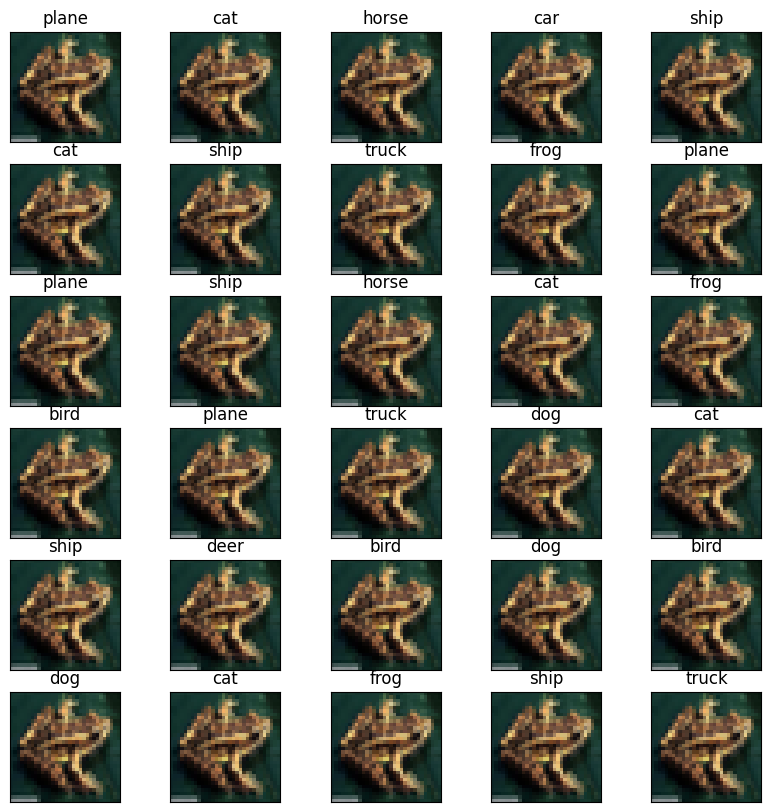

In [5]:
visualize_images()

### Plot Training Results

In [8]:
config, model, train_losses, test_losses, accuracies = load_experiment(exp_name)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label='Train loss')
ax2.plot(test_losses, label='Test loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

ValueError: invalid mode: 'metrics.json'

In [ ]:
visualize_attention(model, "attention.png")

NameError: name 'model' is not defined